# Robust Featureとnon Robust Featureを持つデータセットの作成

## Robust Feature

## model load

In [1]:
ls

models/  robust_dataset.ipynb


In [2]:
import torch

/home/y-sato/anaconda3/envs/vit-py3.8-conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from models.wideresnet import WideResNetProp

In [4]:
# model = WideResNet(depth=34, num_classes=10)
model = WideResNetProp(depth=34)

In [5]:
model.load_state_dict(torch.load('../../model-wideres-epoch99.pt'))

<All keys matched successfully>

In [6]:
ls

models/  robust_dataset.ipynb


## dataset loadする

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=False, transform=transform_train)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

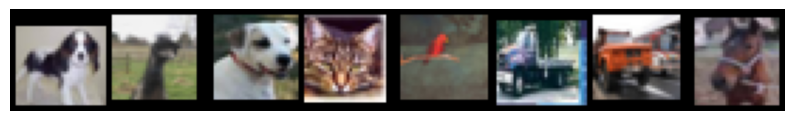

torch.Size([8, 3, 32, 32])

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# データローダーからバッチを取得
data_iter = iter(data_loader)
images, labels = data_iter.next()

# バッチから数枚の画像を表示する関数
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 画像を表示
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.show()
images[:8].shape


In [9]:
x_natural = images[:8].cuda()
type(x_natural)
x_random = images[-8:].cuda()
x_random.shape

torch.Size([8, 3, 32, 32])

## L2-PGD

In [11]:
model = model.cuda()
output = model(x_natural)
print('出力結果 :', output[0].shape)
print('中間特徴量 :', output[1].shape)

出力結果 : torch.Size([8, 10])
中間特徴量 : torch.Size([8, 640, 8, 8])


In [16]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

# epsilon = 8 / 255
epsilon = 0.1
perturb_steps = 1000
batch_size = len(x_natural)
# criterion_kl = torch.nn.KLDivLoss(size_average=False)
criterion_MSE = nn.MSELoss()
model = model.cuda()

# delta = 0.001 * torch.randn(x_natural.shape).cuda().detach()
# delta = Variable(delta.data, requires_grad=True)
x_adv = x_random
x_adv.requires_grad = True
# Setup optimizers
optimizer_delta = optim.SGD([x_adv], lr=0.1)

for _ in range(perturb_steps):
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        # loss = (-1) * criterion_kl(F.log_softmax(model(adv)[1], dim=1),
        #                            F.softmax(model(x_natural)[1], dim=1))
        loss = criterion_MSE(model(x_adv)[1], model(x_natural)[1])
    loss.backward()
    # renorming gradient
    # breakpoint()
    # print(x_adv.grad)
    grad_norms = x_adv.grad.view(batch_size, -1).norm(p=2, dim=1)
    x_adv.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        x_adv.grad[grad_norms == 0] = torch.randn_like(x_adv.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    # x_adv.data.add_(x_natural)
    # x_adv = torch.clamp(x_adv.detach(), 0.0, 1.0).clone().requires_grad_(True) 
    #x_adv = torch.clamp(x_adv, 0.0, 1.0)
    #x_adv.requires_grad_()
    # x_adv.data.renorm_(p=2, dim=0, maxnorm=epsilon)
# x_adv = Variable(x_natural + delta, requires_grad=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


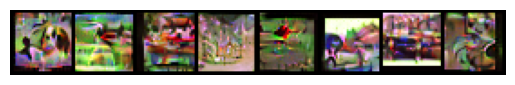

In [17]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))


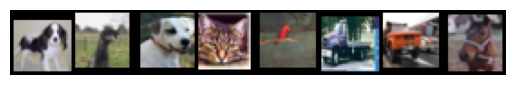

In [18]:
imshow(torchvision.utils.make_grid(x_natural.cpu().detach()))

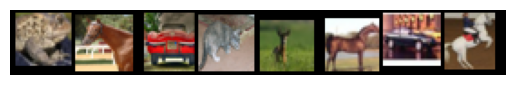

In [19]:
imshow(torchvision.utils.make_grid(images[-8:]))

## non Robust Feature

In [20]:
# standard training model

model_s = WideResNetProp(depth=34)
model_s.load_state_dict(torch.load('../../wideres34-10.pt'))


<All keys matched successfully>

In [21]:
x = images[:8].cuda()
y = labels[:8].cuda()
t = labels[-8:].cuda()

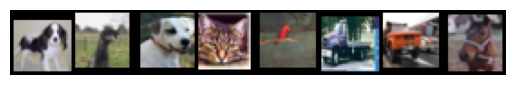

In [22]:
imshow(torchvision.utils.make_grid(x.cpu().detach()))

In [23]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn as nn

# epsilon = 8 / 255
# epsilon = 0.1
perturb_steps = 100
batch_size = len(x)

criterion_CE = nn.CrossEntropyLoss()
model_s = model_s.cuda()

x_adv = x
x_adv.requires_grad = True
# Setup optimizers
optimizer_delta = optim.SGD([x_adv], lr=0.5)

for _ in range(perturb_steps):
    # optimize
    optimizer_delta.zero_grad()
    with torch.enable_grad():
        loss = criterion_CE(model_s(x_adv)[0], t)
    loss.backward()
    # renorming gradient
    grad_norms = x_adv.grad.view(batch_size, -1).norm(p=2, dim=1)
    x_adv.grad.div_(grad_norms.view(-1, 1, 1, 1))
    # avoid nan or inf if gradient is 0
    if (grad_norms == 0).any():
        x_adv.grad[grad_norms == 0] = torch.randn_like(x_adv.grad[grad_norms == 0])
    optimizer_delta.step()
    # projection
    # x_adv = torch.clamp(x_adv.detach(), 0.0, 1.0).clone().requires_grad_(True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


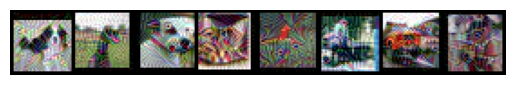

In [24]:
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))

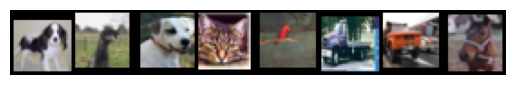

In [25]:
imshow(torchvision.utils.make_grid(images[:8].detach()))

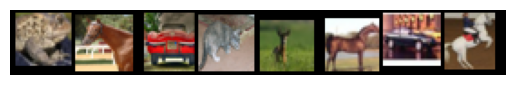

In [26]:
imshow(torchvision.utils.make_grid(images[-8:]))